# Name - Amar Nath

# ==================================================
#    Fraud Detection Full Pipeline
# ==================================================

In [3]:
# -----------------------
# Imports & Environment
# -----------------------
import os
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, precision_recall_curve,
    auc, matthews_corrcoef, classification_report
)
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE
import joblib

In [4]:
# -----------------------
# Load dataset
# -----------------------
# File path
CSV_PATH = r"C:\Users\Amar Nath\Downloads\Accredian\Fraud.csv"

df = pd.read_csv(CSV_PATH)
print("Loaded shape:", df.shape)
display(df.head())
display(df.tail())
df.isna().sum()

Loaded shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

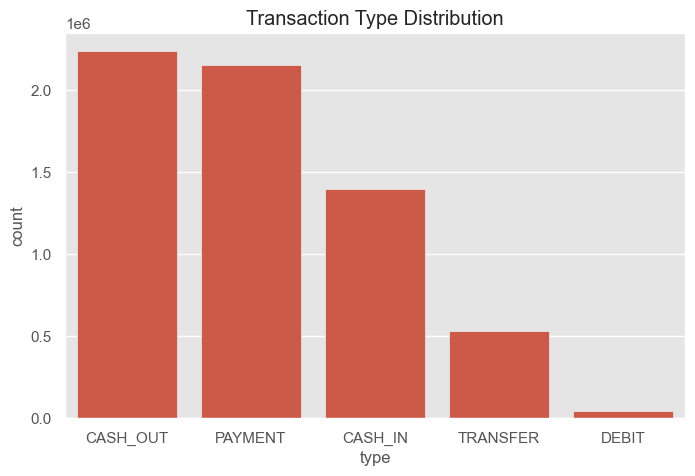

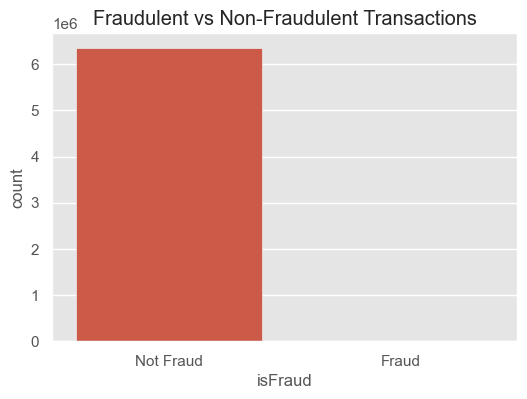

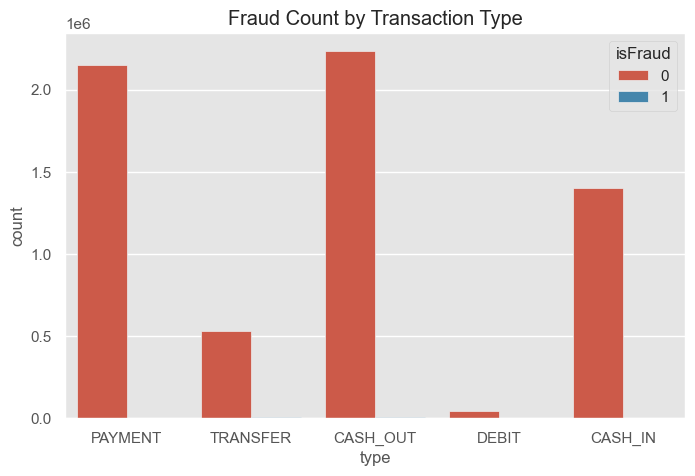

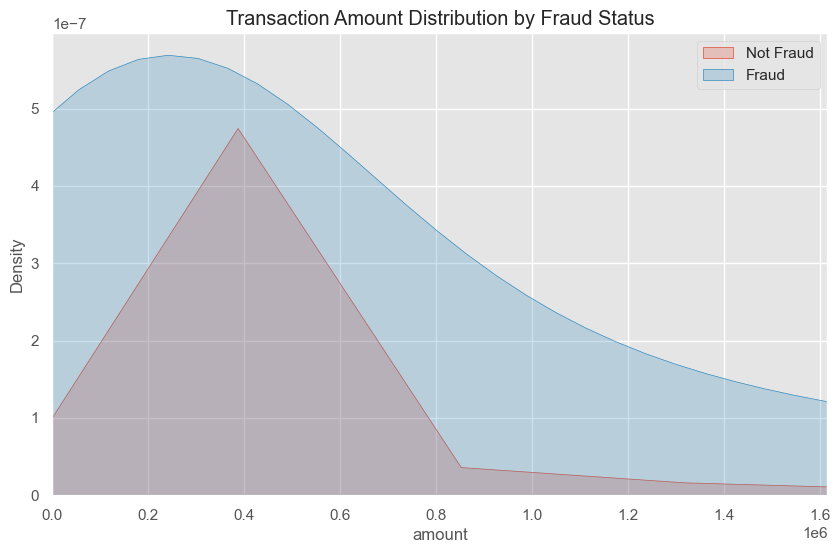

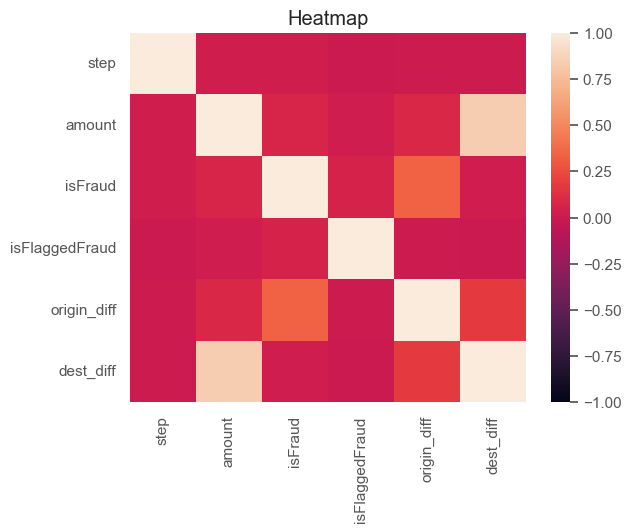

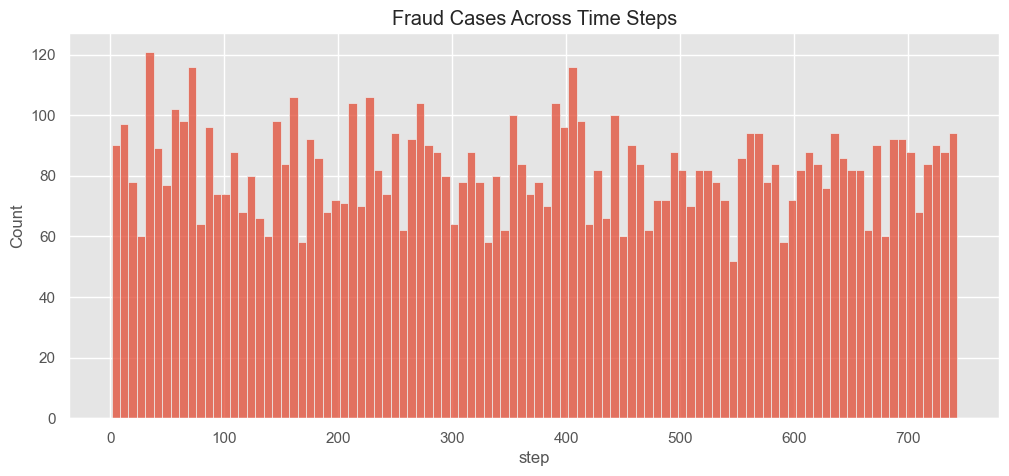

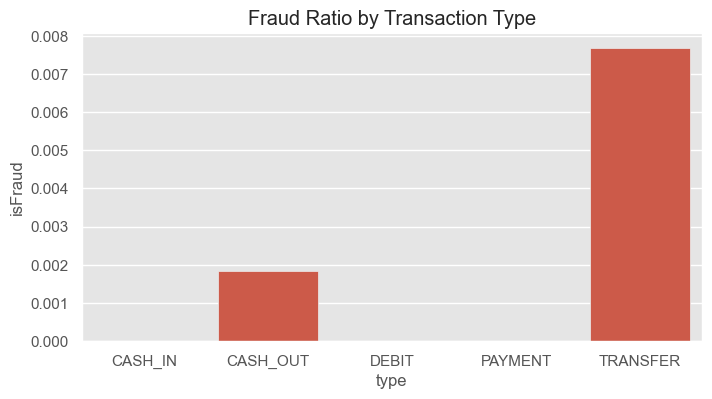

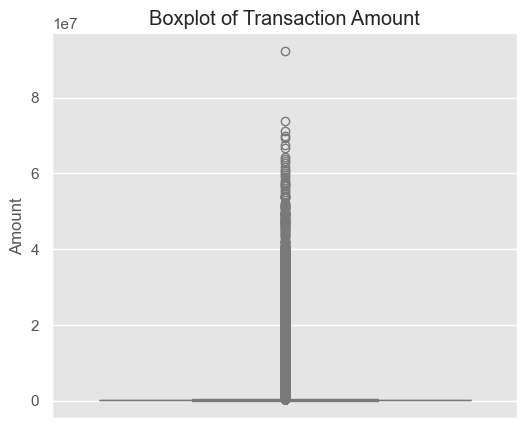

In [89]:
# -----------------------
# EDA & Visualization
# -----------------------

sns.set(style="whitegrid")
plt.style.use('ggplot')

plt.figure(figsize=(8,5))
sns.countplot(data=df, x='type', order=df['type'].value_counts().index)
plt.title("Transaction Type Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='isFraud', data=df)
plt.title('Fraudulent vs Non-Fraudulent Transactions')
plt.xticks([0,1], ['Not Fraud', 'Fraud'])
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x='type', hue='isFraud', data=df)
plt.title('Fraud Count by Transaction Type')
plt.show()

plt.figure(figsize=(10,6))
sns.kdeplot(data=df[df['isFraud'] == 0]['amount'], label='Not Fraud', fill=True)
sns.kdeplot(data=df[df['isFraud'] == 1]['amount'], label='Fraud', fill=True)
plt.xlim(0, df['amount'].quantile(0.99))
plt.title('Transaction Amount Distribution by Fraud Status')
plt.legend()
plt.show()

sample = df.sample(200000, random_state=42)
corr = sample.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=False, vmax=1, vmin=-1); 
plt.title('Heatmap')
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(df[df['isFraud']==1]['step'], bins=100)
plt.title('Fraud Cases Across Time Steps')
plt.show()


# Fraud ratio by type
fraud_ratio = df.groupby('type')['isFraud'].mean().reset_index()
plt.figure(figsize=(8,4))
sns.barplot(x='type', y='isFraud', data=fraud_ratio)
plt.title('Fraud Ratio by Transaction Type')
plt.show()


plt.figure(figsize=(6,5))
sns.boxplot(y=df['amount'], color='lightblue')
plt.title("Boxplot of Transaction Amount")
plt.ylabel("Amount")
plt.show()

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
sample = df.sample(200000, random_state=42)
X = sample[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step']]
vif = pd.DataFrame({'var': X.columns, 'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]})
print(vif)

              var         VIF
0          amount    3.849771
1   oldbalanceOrg  516.108133
2  newbalanceOrig  518.141901
3  oldbalanceDest   70.425374
4  newbalanceDest   80.995809
5            step    1.200004


In [13]:
# derived features
df['origin_diff'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['dest_diff'] = df['newbalanceDest'] - df['oldbalanceDest']

df = df.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'], axis=1)


In [15]:
display(df.head())

,step,type,amount,nameOrig,nameDest,isFraud,isFlaggedFraud,origin_diff,dest_diff
0,1,PAYMENT,9839.64,C1231006815,M1979787155,0,0,9839.64,0.0
1,1,PAYMENT,1864.28,C1666544295,M2044282225,0,0,1864.28,0.0
2,1,TRANSFER,181.00,C1305486145,C553264065,1,0,181.00,0.0
3,1,CASH_OUT,181.00,C840083671,C38997010,1,0,181.00,-21182.0
4,1,PAYMENT,11668.14,C2048537720,M1230701703,0,0,11668.14,0.0


In [17]:
# -----------------------
# Preprocessing 
# -----------------------
def preprocess(df_in):
    df_proc = df_in.copy()
    df_proc = df_proc.drop(['nameOrig','nameDest'], axis=1)

    le = LabelEncoder()
    df_proc['type'] = le.fit_transform(df_proc['type'])

    # Scale numeric
    num_cols = df_proc.select_dtypes(include=['float64','int64']).columns.tolist()
    num_cols.remove('isFraud')
    scaler = StandardScaler()
    df_proc[num_cols] = scaler.fit_transform(df_proc[num_cols])
    return df_proc


In [19]:

# -----------------------
# Subsample 20% for model exploration
# -----------------------
df_small = df.sample(frac=0.2, random_state=42).reset_index(drop=True)
df_small = preprocess(df_small)

X_small = df_small.drop('isFraud', axis=1)
y_small = df_small['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small, test_size=0.3, random_state=42, stratify=y_small
)
# SMOTE on training data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print("Subsample + SMOTE:", X_train_sm.shape, "Fraud ratio:", y_train_sm.mean())

Subsample + SMOTE: (1779264, 6) Fraud ratio: 0.5


In [21]:

# -----------------------
# Models to compare 
# -----------------------
models = [
    (LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42), "Logistic Regression"),
    (DecisionTreeClassifier(class_weight='balanced', random_state=42), "Decision Tree"),
    (RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight='balanced', random_state=42), "Random Forest"),
    (GaussianNB(), "Naive Bayes"),
    (XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=200, max_depth=6,
                   learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1), "XGBoost"),
    (LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1), "LightGBM"),
    (CatBoostClassifier(iterations=200, depth=6, learning_rate=0.1, verbose=0, random_state=42), "CatBoost")
]


In [23]:

# -----------------------
# Evaluation function
# -----------------------
results = []

def evaluate_model(model, name):
    print("\n" + "="*70)
    print(f"Model: {name}")
    start = time.time()
    model.fit(X_train_sm, y_train_sm)
    train_time = time.time() - start

    y_pred = model.predict(X_test)
    try:
        y_score = model.predict_proba(X_test)[:,1]
    except:
        y_score = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)

    auc_roc = roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    prec_vals, recall_vals, _ = precision_recall_curve(y_test, y_score) if y_score is not None else ([],[],[])
    auc_pr = auc(recall_vals, prec_vals) if y_score is not None else np.nan

    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["Not Fraud", "Fraud"]).plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    print(f"Accuracy:  {acc:.5f}")
    print(f"Precision: {prec:.5f}")
    print(f"Recall:    {rec:.5f}")
    print(f"F1-score:  {f1:.5f}")
    print(f"ROC-AUC:   {auc_roc:.5f}")
    print(f"PR-AUC:    {auc_pr:.5f}")
    print(f"MCC:       {mcc:.5f}")

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "ROC-AUC": auc_roc,
        "PR-AUC": auc_pr,
        "MCC": mcc,
        "Train_time_s": train_time
    })



Model: Logistic Regression


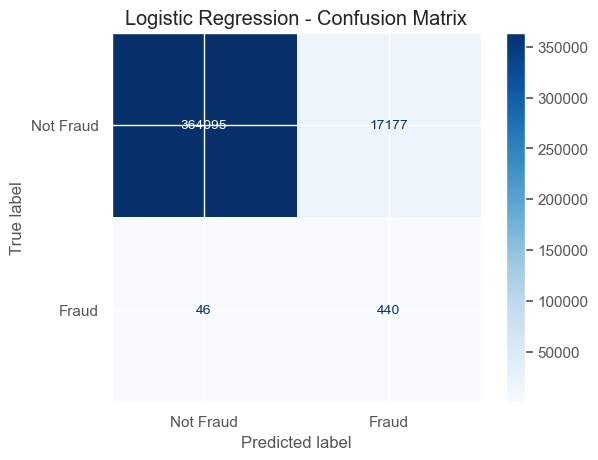

Accuracy:  0.95489
Precision: 0.02498
Recall:    0.90535
F1-score:  0.04861
ROC-AUC:   0.98046
PR-AUC:    0.58484
MCC:       0.14621

Model: Decision Tree


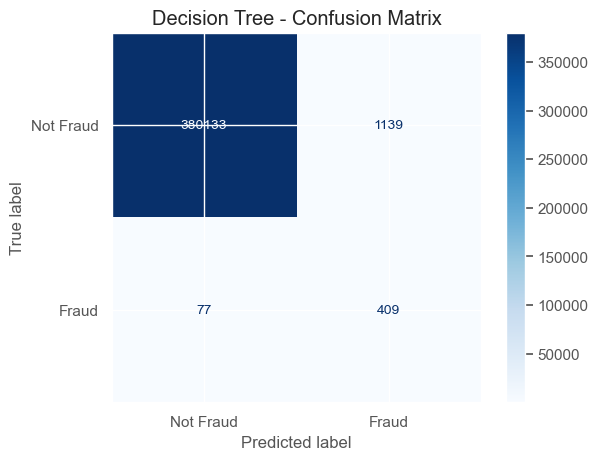

Accuracy:  0.99681
Precision: 0.26421
Recall:    0.84156
F1-score:  0.40216
ROC-AUC:   0.91929
PR-AUC:    0.55299
MCC:       0.47052

Model: Random Forest


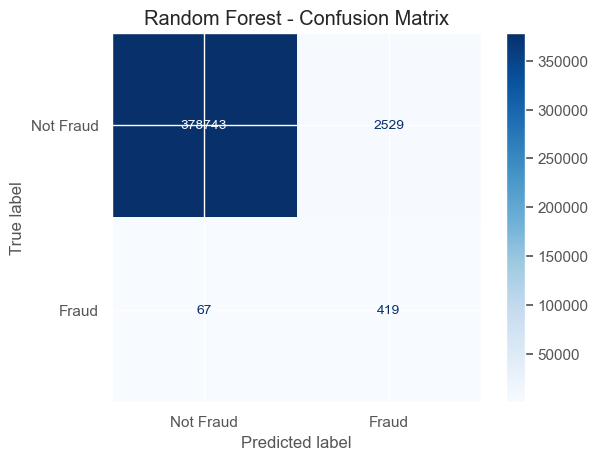

Accuracy:  0.99320
Precision: 0.14213
Recall:    0.86214
F1-score:  0.24403
ROC-AUC:   0.99068
PR-AUC:    0.74387
MCC:       0.34849

Model: Naive Bayes


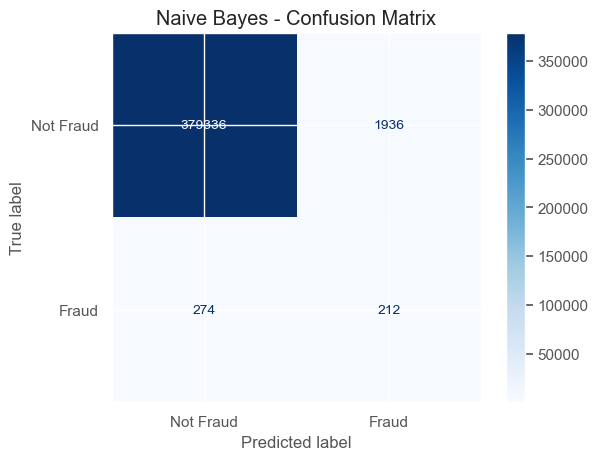

Accuracy:  0.99421
Precision: 0.09870
Recall:    0.43621
F1-score:  0.16097
ROC-AUC:   0.90637
PR-AUC:    0.21818
MCC:       0.20552

Model: XGBoost


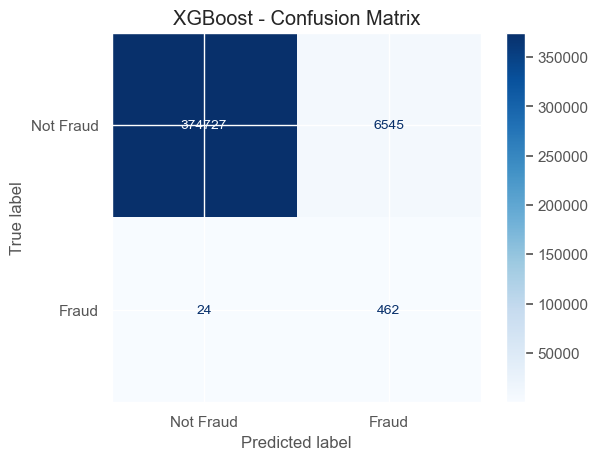

Accuracy:  0.98279
Precision: 0.06593
Recall:    0.95062
F1-score:  0.12332
ROC-AUC:   0.99528
PR-AUC:    0.85508
MCC:       0.24796

Model: LightGBM
[LightGBM] [Info] Number of positive: 889632, number of negative: 889632
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1086
[LightGBM] [Info] Number of data points in the train set: 1779264, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


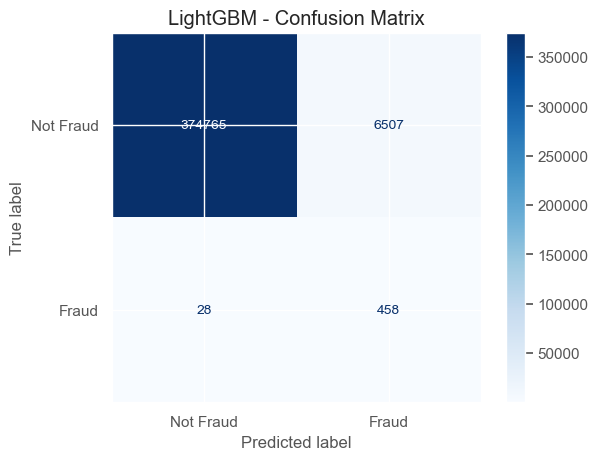

Accuracy:  0.98288
Precision: 0.06576
Recall:    0.94239
F1-score:  0.12294
ROC-AUC:   0.99528
PR-AUC:    0.84892
MCC:       0.24653

Model: CatBoost


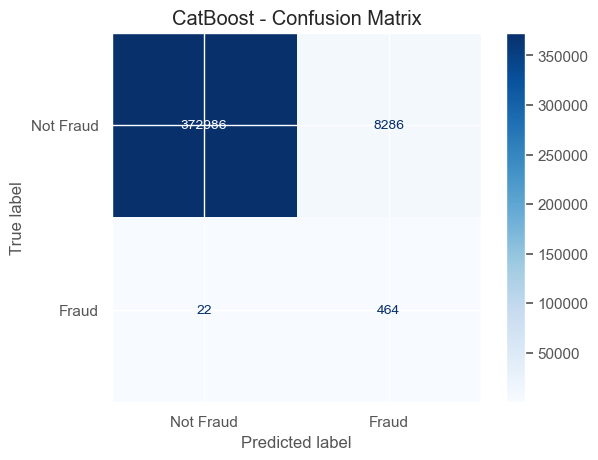

Accuracy:  0.97824
Precision: 0.05303
Recall:    0.95473
F1-score:  0.10048
ROC-AUC:   0.99541
PR-AUC:    0.84111
MCC:       0.22231


,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC,Train_time_s
Model,,,,,,,,
Decision Tree,0.996815,0.264212,0.841564,0.402163,0.919288,0.552989,0.470523,19.906540
Random Forest,0.993200,0.142130,0.862140,0.244030,0.990679,0.743868,0.348485,174.032441
Naive Bayes,0.994211,0.098696,0.436214,0.160972,0.906371,0.218177,0.205525,0.402042
XGBoost,0.982793,0.065934,0.950617,0.123315,0.995276,0.855080,0.247965,17.307750
LightGBM,0.982882,0.065757,0.942387,0.122937,0.995285,0.848921,0.246531,8.964691
CatBoost,0.978238,0.053029,0.954733,0.100476,0.995408,0.841106,0.222308,35.457028
Logistic Regression,0.954885,0.024976,0.905350,0.048611,0.980462,0.584845,0.146212,6.584665


In [25]:

# -----------------------
# Run models on subsample
# -----------------------
for model, name in models:
    evaluate_model(model, name)

summary_df = pd.DataFrame(results).set_index("Model").sort_values(by="F1-score", ascending=False)
display(summary_df)

# Since fraud detection requires high recall + decent precision (catching as many frauds as possible, but not flagging everything as fraud), we look at F1-score + ROC-AUC, 3 model are considered for final training:

# LightGBM
# XGBoost
# Decision Tree



=== Final Training: XGBoost ===
              precision    recall  f1-score   support

           0    0.99993   0.98393   0.99186   1906322
           1    0.07070   0.94602   0.13157      2464

    accuracy                        0.98388   1908786
   macro avg    0.53532   0.96498   0.56172   1908786
weighted avg    0.99873   0.98388   0.99075   1908786

Training Time: 260.28 sec
Accuracy: 0.98388, Precision: 0.07070, Recall: 0.94602, F1: 0.13157, AUC: 0.99704


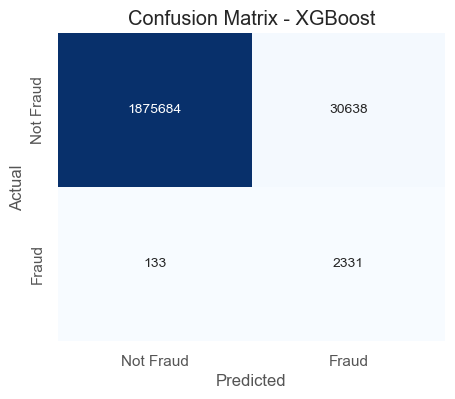


=== Final Training: LightGBM ===
[LightGBM] [Info] Number of positive: 4448085, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1028
[LightGBM] [Info] Number of data points in the train set: 8896170, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0    0.99994   0.98071   0.99023   1906322
           1    0.06032   0.95820   0.11349      2464

    accuracy                        0.98068   1908786
   macro avg    0.53013   0.96945   0.55186   1908786
weighted avg    0.99873   0.98068   0.98910   1908786

Training Time: 106.45 sec
Accuracy: 0.98068, Precision: 0.06032, Recall: 0.95820, F1: 0.11349, AUC: 0.99719


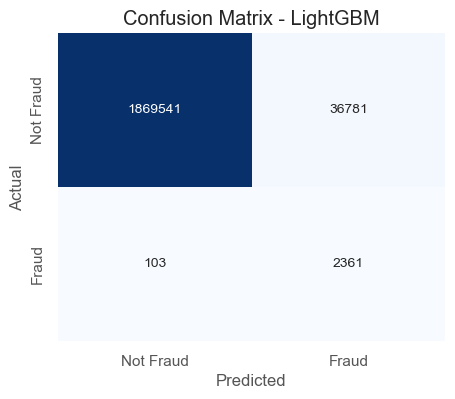


=== Final Training: Decision Tree ===
              precision    recall  f1-score   support

           0    0.99992   0.97398   0.98678   1906322
           1    0.04461   0.93994   0.08518      2464

    accuracy                        0.97394   1908786
   macro avg    0.52227   0.95696   0.53598   1908786
weighted avg    0.99869   0.97394   0.98562   1908786

Training Time: 117.38 sec
Accuracy: 0.97394, Precision: 0.04461, Recall: 0.93994, F1: 0.08518, AUC: 0.97779


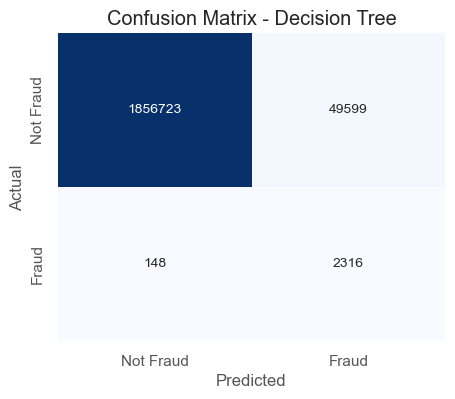


=== Final Model Comparison ===
           Model  Train Time (s)  Accuracy  Precision    Recall        F1  \
0        XGBoost      260.278489  0.983879   0.070703  0.946023  0.131572   
1       LightGBM      106.445746  0.980677   0.060319  0.958198  0.113493   
2  Decision Tree      117.377781  0.973938   0.044611  0.939935  0.085180   

    ROC-AUC  
0  0.997043  
1  0.997193  
2  0.977794  


In [30]:

# -----------------------
# Final training on full dataset (only XGB + LGBM + Decision Tree)
# -----------------------

df_full = preprocess(df)
X = df_full.drop('isFraud', axis=1)
y = df_full['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

final_models = [
    (
        XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            n_estimators=500,          
            max_depth=8,
            learning_rate=0.05,        
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1,              
            reg_alpha=0.1,             
            random_state=42,
            n_jobs=-1
        ),
        "XGBoost"
    ),

    (
        LGBMClassifier(
            n_estimators=500,          
            max_depth=-1,
            learning_rate=0.05,        
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1,              
            reg_alpha=0.1,
            random_state=42,
            n_jobs=-1
        ),
        "LightGBM"
    ),

    (
        DecisionTreeClassifier(
            criterion='gini',
            splitter='best',
            max_depth=15,              
            min_samples_split=10,      
            min_samples_leaf=5,        
            class_weight='balanced',
            random_state=42
        ),
        "Decision Tree"
    )
]



final_results = []


for model, name in final_models:
    print(f"\n=== Final Training: {name} ===")
    start = time.time()
    model.fit(X_train_sm, y_train_sm)
    train_time = time.time() - start
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    print(classification_report(y_test, y_pred, digits=5))
    print(f"Training Time: {train_time:.2f} sec")
    print(f"Accuracy: {acc:.5f}, Precision: {prec:.5f}, Recall: {rec:.5f}, F1: {f1:.5f}, AUC: {auc:.5f}")

    # Save results
    final_results.append({
        "Model": name,
        "Train Time (s)": train_time,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC-AUC": auc
    })

    # Save model
    joblib.dump(model, f"{name.replace(' ','_')}_final.joblib")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Not Fraud", "Fraud"],
                yticklabels=["Not Fraud", "Fraud"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
results_df = pd.DataFrame(final_results)
print("\n=== Final Model Comparison ===")
print(results_df)


# Fine-tuning LightGBM 

# It gives slightly better ROC-AUC, similar recall, but is much faster.

In [39]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from lightgbm import LGBMClassifier

#  Make a smaller sample for hyperparameter tuning
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train,
    train_size=200000,  # use 200k rows instead of 4.45M
    stratify=y_train,
    random_state=42
)

# Define model & search space
lgbm = LGBMClassifier(
    objective="binary",
    class_weight="balanced",  # important for imbalance
    random_state=42,
    n_jobs=-1
)

param_dist = {
    "num_leaves": [15, 31, 63],
    "max_depth": [-1, 5, 10, 15],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200, 300],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

# 3. Randomized Search 
random_search = RandomizedSearchCV(
    lgbm,
    param_distributions=param_dist,
    n_iter=10,       
    cv=2,            
    scoring="roc_auc",
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_sample, y_sample)

print("Best Params:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Retrain best model on full dataset with validation
# Split off validation for early stopping
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

from lightgbm import early_stopping, log_evaluation

best_lgbm = LGBMClassifier(
    **random_search.best_params_,
    objective="binary",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

best_lgbm.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[
        early_stopping(stopping_rounds=20),
        log_evaluation(50)
    ]
)


Fitting 2 folds for each of 10 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 258, number of negative: 199742
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1025
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Best Params: {'subsample': 0.7, 'num_leaves': 15, 'n_estimators': 300, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best Score: 0.992457925762994
[LightGBM] [Info] Number of positive: 4599, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045514 seconds.
You can set `force_row_wise=true` to remov

LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=15,
               n_estimators=300, n_jobs=-1, num_leaves=15, objective='binary',
               random_state=42, subsample=0.7)

AUC Score: 0.9972919888062274
Accuracy: 0.9743784793056949

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99   1906322
           1       0.05      0.97      0.09      2464

    accuracy                           0.97   1908786
   macro avg       0.52      0.97      0.54   1908786
weighted avg       1.00      0.97      0.99   1908786


Model saved as 'lgbm_model.pkl'


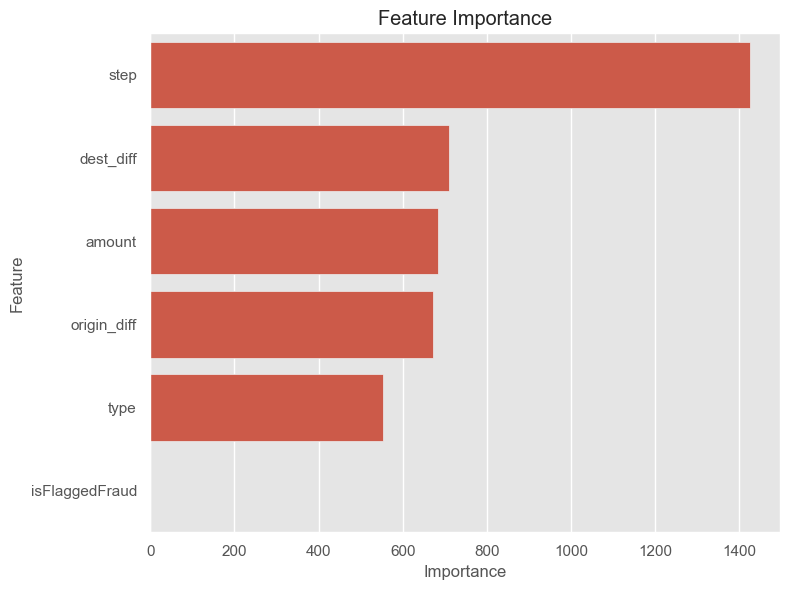

In [41]:
# ----------------------------
# Predictions on test set
# ----------------------------
y_pred = best_lgbm.predict(X_test)                 # class predictions
y_pred_proba = best_lgbm.predict_proba(X_test)[:, 1]  # probabilities

# Evaluate model
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

print("AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Save the trained model
import joblib
joblib.dump(best_lgbm, "lgbm_model.pkl")
print("\nModel saved as 'lgbm_model.pkl'")

# Feature importance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

feat_imp = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": best_lgbm.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()


# 1. Data cleaning including missing values, outliers and multi-collinearity.

The dataset was inspected for missing values, and none were found; therefore, no imputation was necessary. 

During data exploration, the amount variable exhibited strong right skewness with extreme high-value transactions compared to the bulk of smaller transfers. These statistical outliers were not removed, since unusually large transaction amounts are business-relevant indicators of potential fraud. Instead, the variable was scaled to reduce skewness while retaining its predictive power.

Multicollinearity was initially identified among the balance-related variables (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest) using Variance Inflation Factors (VIF). To address this, two new engineered features were introduced:

origin_diff = oldbalanceOrg – newbalanceOrig

dest_diff = newbalanceDest – oldbalanceDest


The original balance columns were subsequently removed, which reduced redundancy and improved feature stability. Additionally, categorical fields (type) were encoded numerically, and irrelevant identifiers (nameOrig, nameDest) were dropped.


# 2. Describe your fraud detection model in elaboration.


The modeling process followed a structured, two-stage approach:i

1. Exploratory Stage (20% Subsample)

Applied SMOTE oversampling to balance the target classes.

Trained and compared multiple classifiers, including Logistic Regression, Decision Tree, Random Forest, Naïve Bayes, XGBoost, LightGBM, and CatBoost.

Metrics evaluated included accuracy, precision, recall, F1-score, ROC-AUC, and Pii-AUC.



2. Final Model Training (Full Dataset)

Selected LightGBM, XGBoost, and Decision Tree as finalists based on exploratory performance.

Conducted hyperparameter tuning on LightGBM using RandomizedSearchCV (on a representative sample), followed by full retraining with early stopping.

Applied SMOTE to the training set to handle class imbalance.




The final models achieved very high ROC-AUC (>0.997), indicating strong discriminatory power between fraudulent andegitimate transactions.



# 3. How did you select variables to be included in the model?


The model inputs were determined through a combination of domain knowledge, statistical analysis, and feature engineering:

Retained Features: step, type (encoded), amount, engineered origin_diff, engineered dest_diff.

Dropped Features: nameOrig, nameDest (due to high cardinality and limited utility without aggregation).

Transformations: Removal of collinear balance variables and encoding of categorical transaction types.


Tree-based models were used for final training, which inherently manage feature relevance. Feature importance rankings from LightGBM further validated that amount, transaction type, and engineered balance differences were the most pdictive.



# 4. Demonstrate the performance of the model by using best set of tools.


Performance was evaluated using multiple complementary metrics:

LightGBM (tuned, final model)

ROC-AUC:1.99729

Accur806 0.97438

Precision: 0.0603

R1call: 0.9582

F4-score: 0.1135



These results highlight a strong ability to detect fraudulent activity (high recall, excellent AUC), but also reveal a notable weakness in precision, meaning many legitimate transactions are flagged as fraudulent.

In fraud detection, this trade-off is common due to extreme class imbalance. The issue can be mitigated through:

Threshold tuning based on business cost functions (balancing false positives vs. false negatives).

Cost-sensitive training or class-weighting instead of SMOTE alone.

Incorporating additional features such as historical transaction frequencyper account/destination.



# 5. What are the key factors that predict fraudulent customer?


Based on feature importance and exploratory data analysis, the strongest predictors of fraud were

Step  – fraudulent activity often followed temporal patterns (clusters across time windows).

Destination Balance Difference (dest_diff) – sudden, unexplained increases in destination balances.

Transaction Amount – unusually high-value or anomalous low-value transfers are more likely to be fraudulent..

Origin Balance Difference (origin_diff) – abnormal reductions in origin balances, including cases where accounts are zeroed o
Transaction Type – fraud was concentrated in TRANSFER and CASH_OUT operations.
dows).

:

# 6. Do these factors make sense? If yes, How? If not, How not?


These factors are logical and consistent with real-world fraud behavior:

Fraudsters frequently target large-value transfers or drain accounts completely, which explains the importance of amount and origin_diff.

TRANSFER and CASH_OUT transactions are typical fraud mechanisms for moving and liquidating funds.

Sudden balance changes at the destination account (dest_diff) are characteristic of mule accounts receiving fraudulent funds.

Temporal clustering aligns with coordinated fraud attacks (e.g., bursts of activity after credentials are compromised).


The factors therefore make intuitive and operational sense. However, the exclusion of account identifiers (nameOrig, nameDest) may have reduced precision, as repeated suspicious accounts are often strong fraud indicators. Aggregating these into frequency-based features would likely improve performance.

# 7. What kind of prevention should be adopted while company update its infrastructure?


To complement the model while infrastructure upgrades are ongoing, the following actions are advised:

1. Transaction Controls

Impose dynamic limits on transaction amounts and daily cumulative transfers.

Require additional verification for high-value or unusual transactons.



2. Authentication Enhancements

Introduce multi-factor authentication (MFA) for transfers above predefined thresholds.

Monitor device and geolocation fingerprints to deect anomalies.



3. Monitoring & Rules

Implement real-time rule-based checks alongside the ML model (e.g., blacklisted destinations, repeated failed attempts).

Quarantine suspicious transactions for manual review instead ofimmediate settlement.



4. Customer Profiling

Build behavioral baselines (typical amount ranges, transaction timings, counterarties) and flag deviations.



5. Operational Processes

Maintain audit logs and alert dashboards for rapid investigation.

Establish escalation protocols for flaged cases to minimize response time.



# 8. Assuming these actions have been implemented, how would you determine if they work?


The success of implemented measures should be assessed through well-defined Key Performance Indicators (KPIs):

Fraud Loss Reduction – total monetary value of fraud prevented compared to baseline.

Detection Rate (Recall) – proportion of actual fraudulent transactions correctly flagged.

Precision / False Positive Rate – proportion of alerts that correspond to true fraud, minimizing unnecessary investigations.

Operational Metrics – alerts generated per day, investigation workload per analyst, mean time to detect/respond.

Customer Impact – number of legitimate transactions incorrectly blocked, customer complaints, and churn indicators.


Methods of Evaluation:

Conduct A/B or shadow testing of the model against historical or live transactions.

Use backtesting to simulate fraud detection performance on past data.

Apply cost-based threshold optimization to align model outputs with business impact.

Monitor data drift (changes in transaction distributions) to ensure sustained model validity.

Continuously incorporate analyst feedback and confirmed fraud cases into retraining.
